# Shortest Paths with Python

Efficiently finding shortest paths in graphs is very important for many different kinds of applications, from social networks and internet routing to road navigation.
There exists several ways to compute paths between any two nodes of a graph with python, so I'll explore a few.

## Getting a Graph
First, we need a graph to play with. We will read a file that I've prepared, which contains:
- a graph of about 25,000 vertices representing part of the New-York road network,
- the latitude/longitude coordinates of the vertices of the graph.

In [1]:
import cPickle
with open('new-york.pkl', 'rb') as f:
    graph_info = cPickle.load(f)
graph = graph_info['adj']
coordinates = graph_info['coords']

The nodes are represented by integer IDs that correspond to their OpenStreetMap IDs.
The graph is represented as an adjacency list, which is a python dict mapping each node $i$ to a list of tuples $(j, w_{i,j})$, where $j$ is a accessible from $i$ (i.e., there is an edge $i \rightarrow j$) and $w_{i,j}$ is the weight of the edge $i \rightarrow j$.
This makes it a directed and weighted graph.

### A look at the Graph
Because the vertices already have coordinates, we can easily represent the graph more or less as it would show on Google Maps (except the look'n'feel, perhaps).

Plotting everything is **slow**, so the code below plots only 10% of the edges. You can set `p=1` in the code below to plot all the edges (but this might take quite a while!)

took 10.6869359016 secs.


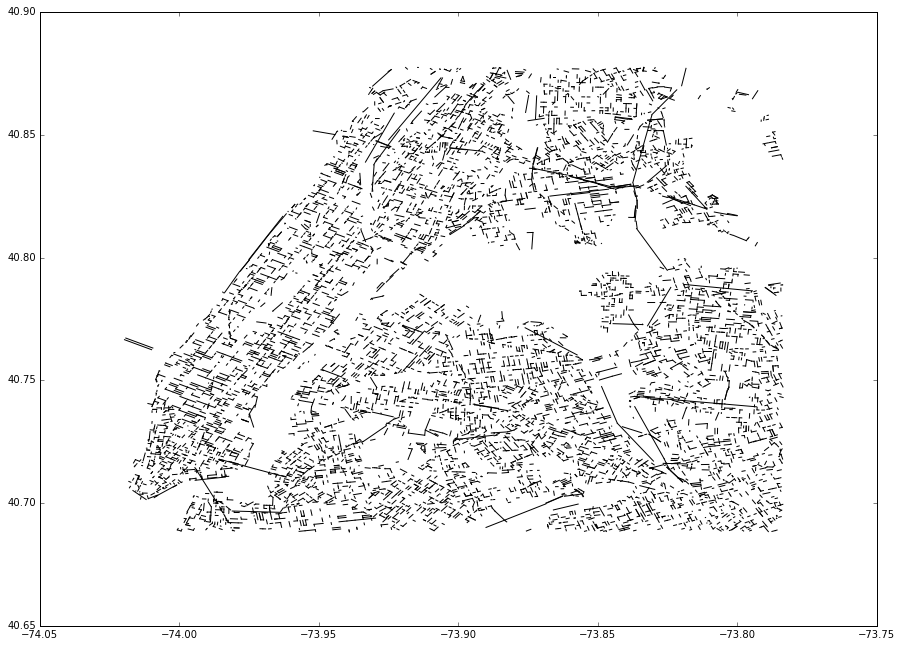

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time

def plot_graph(graph, coordinates, p=0.1):
    fig = plt.figure(figsize=(15,11))
    segments_plotted = set()
    for node in graph.keys():
        neighbors = graph[node]
        y1, x1 = coordinates[node]
        for neighbor in neighbors:
            y2, x2 = coordinates[neighbor[0]]
            if random.random() < p:
                plt.plot([x1, x2], [y1, y2], 'k-')

tic = time.time()
plot_graph(graph, coordinates, p=0.1)
tac = time.time()
print 'took {t} secs.'.format(t=tac-tic)

## Specifying Source and Destination 
Nobody likes to indicate OpenStreetMaps ID when looking how to get from A to B. It's much more convenient to use latitude and longitude coordinates! But then: how does one efficiently map these coordinates to the closest vertices in the graph? Using a 2-d tree, of course.

In [3]:
import numpy as np
from scipy.spatial import KDTree

points = np.array([coordinates[p] for p in coordinates.keys()])
node_indices = np.array(coordinates.keys())
tree = KDTree(points)

def get_nearest_neighbors(x, k=1):
        """
        :param x: ndarray representing a list of points to query
        :param k: number of nearest neighbors to return
        :return: tuple containing: array of node indices, array of distances
        """
        distances, indices = tree.query(x, k)
        return node_indices[indices], distances

Cool, so now we are all set to get the indices of nodes which are the closest to some coordinates. Let's pick some source/destination nodes this way:

In [4]:
# Say we want to go from there:
origin_coords = [40.7080, -73.9088]
# to there:
destination_coords = [40.8226, -73.9421]

# use our k-d tree to get corresponding node indices
orig_dest = get_nearest_neighbors(np.array([origin_coords, destination_coords]), k=1)[0]
origin = orig_dest[0]
destination = orig_dest[1]

## Networkx
Let's try to see how we can use all this stuff. We can easily compute shortest paths using the [`networkx`](https://networkx.github.io/) python graph processing package.

In [5]:
import networkx as nx
import time

# Build our networkx graph
G = nx.Graph()
for n1 in graph:
    for n2, w in graph[n1]:
        G.add_edge(n1, n2, {'weight': w})
        
# Compute the shortest path!
tic = time.time()
path = nx.dijkstra_path(G, origin, destination)
tac = time.time()
print 'computed path of length {l} in {t} ms.'.format(l=len(path), t=(tac-tic)*1e3)

computed path of length 179 in 175.050973892 ms.


As you can see, `networkx` is pretty fast already; on my laptop it takes about 160 ms. But is it correct? Let's see if we can look at this path on an *actual* map.

## Showing Paths on a Map
There's a nice package called [`folium`](https://github.com/python-visualization/folium), which we can use to easily plot a path on a map.

In [6]:
import folium

path_coordinates = np.array([coordinates[n] for n in path])
median_path_coord = np.median(path_coordinates, axis=0)
map_osm = folium.Map(location=[c for c in median_path_coord])
for i, point in enumerate(path_coordinates):
    map_osm.add_children(folium.Marker(point, popup=str(i)))
map_osm.add_children(folium.LatLngPopup())
map_osm

Besides the fact that it's using one-ways in a somewhat unconventional fashion, it looks like it might not be the longest path!

## Home-made Dijkstra
The fun part of playing with algorithms is when you get to implement them yourself. Let's do it for Dijkstra!

In [7]:
import heapq

def dijkstra(graph, source, destination):
    visited = set()
    prevs = {source: None}  # previous nodes on paths
    heap = []  # min heap queue that contains (distance, node_id), sorted by distance
    node2distance = {source: 0.0}  # distances of nodes to source
    current = source
    found = False  # keep track of whether a path exists between source and destination

    while not found:
        if current == destination:
            found = True
            break
        visited.add(current)

        current_dist = node2distance[current]
        for (node, weight) in graph[current]:
            if node not in node2distance or node2distance[node] > current_dist + weight:
                distance = current_dist + weight
                prevs[node] = current
                heapq.heappush(heap, (distance, node))
                node2distance[node] = distance

        if len(heap) == 0:
            break
        else:
            # find next current node (among nodes that have not yet been visited)
            found_current = False
            while not found_current:
                current = heapq.heappop(heap)[1]
                if current not in visited:
                    found_current = True


    """ Get and return path from source to destination
    """
    if found:
        path = [destination]
        while True:
            prev = prevs[path[-1]]
            if prev is None:
                break
            else:
                path += [prev]
        return path[::-1]
    else:
        print 'destination not found. Is the graph connected?'
        return []

Let's see how this one does:

In [8]:
tic = time.time()
path = dijkstra(graph, origin, destination)
tac = time.time()
print 'computed path of length {l} in {t} ms.'.format(l=len(path), t=(tac-tic)*1e3)

computed path of length 179 in 109.065771103 ms.


On my laptop, it takes about 110 ms, which is 50 ms faster than `networkx`. Not bad!

## Using Sparse Matrices
Sparse Matrices are an efficient way to represent graphs that are not too dense (where most node pairs are not connected together), such as road networks. [`scipy`](http://www.scipy.org/) provides good support for computation over sparse matrices. The nice thing is that behing the scenes `scipy` uses routines written in C. Let's see what it looks like. To start with, we'll build a `dok_matrix`, which can be efficiently built and later transformed to other kinds of sparse matrices (see these [Scipy lectures](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html) for explanations on the various sparse matrix classes).

In [9]:
from scipy.sparse import dok_matrix

# keep track of mapping between node IDs and matrix indices:
id_to_mat = dict()
mat_to_id = dict()

def build_distance_matrix(graph):
    """ Builds a (sparse) distance matrix representation of the graph
    """
    n = len(graph)
    mat = dok_matrix((n, n))  # the sparse matrix; we construct it using a dok_matrix
    
    current_index = [0]  # modifiable from inner scope
    
    def getset_node_to_index_mapping(node_id):
        """ helper function to store ID <--> matrix_index mappings
        """
        if node_id not in id_to_mat:
            id_to_mat[node_id] = current_index[0]
            mat_to_id[current_index[0]] = node_id
            current_index[0] = current_index[0] + 1
        return id_to_mat[node_id]
    
    for id1 in graph:
        i = getset_node_to_index_mapping(id1)
        for (id2, weight) in graph[id1]:
            j = getset_node_to_index_mapping(id2), 
            mat[i, j] = weight
    return mat

tic = time.time()
graph_dok_matrix = build_distance_matrix(graph)
tac = time.time()
print 'computed dok matrix in {t} s.'.format(t=(tac-tic))

computed dok matrix in 6.78396296501 s.


Now that we have a sparse matrix representation of our graph, we can use `scipy`'s shortest path routines on it.

In [10]:
from scipy.sparse import csr_matrix, bsr_matrix, coo_matrix, csc_matrix, lil_matrix

tic = time.time()
# decide here what kind of sparse matrix we want to use:
sparse_matrix = csr_matrix(graph_dok_matrix)
tac = time.time()
print 'built sparse matrix in {t} ms'.format(t=(tac-tic)*1e3)

built sparse matrix in 119.143009186 ms


Let's define a method to compute the shortest path from a sparse representation:

In [11]:
from scipy.sparse.csgraph import dijkstra as scipy_dijkstra

def sparse_dijkstra(matrix, source, destination):
    _, preds = scipy_dijkstra(matrix, indices=id_to_mat[source], return_predecessors=True)
    
    # build the path:
    path = [destination]
    i = id_to_mat[source]
    while path[-1] != source:
        j = id_to_mat[path[-1]]
        path.append(mat_to_id[preds[j]])
    return path

And let's see how fast it is!

In [12]:
tic = time.time()
path = sparse_dijkstra(sparse_matrix, origin, destination)
tac = time.time()
print 'computed path of length {l} in {t} ms.'.format(l=len(path), t=(tac-tic)*1e3)

computed path of length 179 in 16.5531635284 ms.


Of course, the results depend on the kind of sparse matrix that is being used. On my laptop, I obtain the following (very approximate) results: 

| Sparse Matrix | Time to build from `dok_matrix` | Time to find shortest path |
|------|------|
| `dok_matrix` | - | 140 ms|
| `lil_matrix` | 300 ms | 45 ms|
| `coo_matrix` | 125 ms | 16 ms|
| `bsr_matrix` | 140 ms | 15 ms|
| `csc_matrix` | 125 ms | 13 ms|
| `csr_matrix` | 125 ms | 11 ms|

Pretty impressive improvements over our previous pure python approaches! It's about 10x faster to find the shortest path using a `csr_matrix` than with our dijkstra implementation. Note that the gains might be less straightforward if your graph is dynamic. In this case, maintaining an adjacency list or a `dok_matrix` is more efficient (than, say, maintaining a `csr_matrix`, which are complex to modify), but then you need time to convert to a `csr_matrix`.

An other thing to note: As we used it, `scipy`'s `dijkstra` function returns an array of size $n$ containing the predecessors for all nodes. So unlike our implementation above, which exits the loop as soon as it hits the destination, this vector allows you to compute the shortest path from the origin to *any destination*. It's also possible to use these algorithms to compute an $n \times n$ matrix that contains predecessors for all origins, and thus allows you to compute paths between any two nodes. This is unlikely to be convenient for large graphs though, as it requires $O(n^2 \log n)$ computation and $O(n^2)$ storage.

## Comparison
Let's try now to compare our methods more properly. We'll sample $N$ origin-destination pairs uniformly at random and compute shortest paths for all of them (if it exists).

node 3789768800 not reachable from 42474104; skipping.


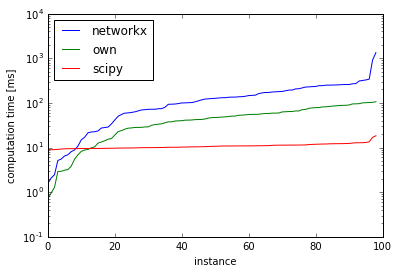

In [13]:
import random

def measure_duration(f, *xargs):
    """ A function to measure execution times, which I should have written a long time ago
    """
    tic = time.time()
    ret_vals = f(*xargs)
    tac = time.time()
    return (ret_vals, (tac-tic)*1e3)

N = 100
durations = []
for i in xrange(N):
    origin = random.choice(graph.keys())
    destination = random.choice(graph.keys())
    try:
        _, duration_nx = measure_duration(nx.dijkstra_path, G, origin, destination)
    except Exception as e:
        print str(e) + '; skipping.'
        continue
    _, duration_own = measure_duration(dijkstra, graph, origin, destination)
    _, duration_scipy = measure_duration(sparse_dijkstra, sparse_matrix, origin, destination)
    durations.append((duration_nx, duration_own, duration_scipy))

durations = np.array(durations)
names = ['networkx', 'own', 'scipy']
fig = plt.figure()
for i in xrange(3):
    plt.semilogy(sorted(durations[:,i]), label=names[i])
plt.legend(loc='best')
plt.xlabel('instance')
plt.ylabel('computation time [ms]')

`scipy` performs consistently well across all origin-destination pairs (about 10 ms in my case). This is because it always computes paths from a source to all other nodes, whereas the other two methods exit as soon as they hit the destination. Note that this is still faster than `scipy` in some cases, when the destination is close enough to the origin (about 10-20% of instances in my case).

## So Which One Should I Use?
In case of doubt, use `scipy` if you can, as its C implementation makes it perform consistently well. However, do not rule out a python-based implementation if your origin-destination pairs tend to be close to each other and/or if your graph is highly dynamic, in which case maintaining `scipy` sparse matrices may outweight their benefits.